In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
from zlib import crc32
import numpy as np
%matplotlib inline

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Observations I made:
1. Spike near end of housing_median_age
2. Spike near end of median house value
3. Longitudes have two very high peaks, which means population is concentrated along a particular vertical line
4. Latitude shows similar trend, indicating population is concentrated along two specific horizontal belts
5. Histograms have very left skewed distributions for total_rooms, total_bedrooms, households and median income

# Observations further studied from book:
1. Median income also shows a minor spike near the end and also the values don't seem to be in USD. On further investigation it was understood that the data collected was scaled to imply tens of thousands of dollars and the values were capped at 15.0001 for any value higher and 0.49999 for any value lower 

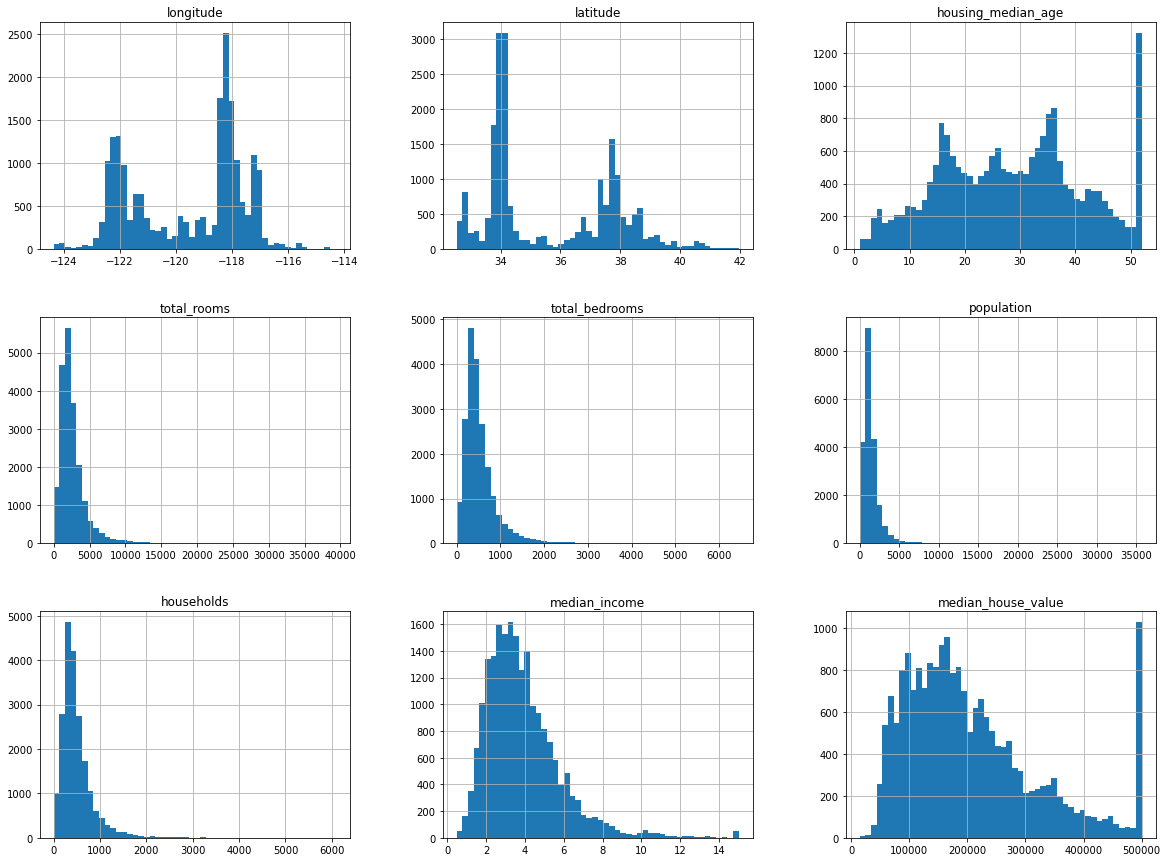

In [10]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

In [11]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [12]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

These train test methods as per book does not give a proper representation of the strata wise split. It might randomly favour one strata or the other. We would need to decide on income levels and accordingly spread the train and test sets.

The income categories thus decided and implemented below, are discrete values, starting at 0 and ending at 6.

[5, 4, 3, 2, 1]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


<AxesSubplot:>

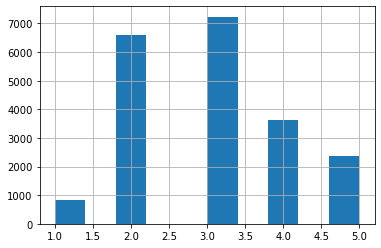

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

print(housing["income_cat"].unique())
housing["income_cat"].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To understand the benefits of stratified sampling we'll prepare the comparison table of the percentage population for both train and test sets obtained in each of the methods.

As we understand all the deviations are far less in stratified sampling compared to random sampling.

In [17]:
stratified_train_p = strat_train_set["income_cat"].value_counts()/len(strat_train_set)
train_set["income_cat"] = pd.cut(train_set["median_income"], bins = [0., 1.5, 3., 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
random_train_p = train_set["income_cat"].value_counts()/len(train_set)
overall_train_p = housing["income_cat"].value_counts()/len(housing)

train_p_comparison = pd.DataFrame({"Overall distribution" : overall_train_p,
                                  "Random sampling" : random_train_p,
                                  "Stratified sampling" : stratified_train_p})
train_p_comparison["Random Sampling Deviation"] = (train_p_comparison["Overall distribution"] - train_p_comparison["Random sampling"])/train_p_comparison["Overall distribution"]
train_p_comparison["Stratified Sampling Deviation"] = (train_p_comparison["Overall distribution"] - train_p_comparison["Stratified sampling"])/train_p_comparison["Overall distribution"]

display(train_p_comparison)

<ipython-input-17-bd2eb4df7c9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["income_cat"] = pd.cut(train_set["median_income"], bins = [0., 1.5, 3., 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])


,Overall distribution,Random sampling,Stratified sampling,Random Sampling Deviation,Stratified Sampling Deviation
3,0.350581,0.348595,0.350594,0.005666,-0.000035
2,0.318847,0.317466,0.318859,0.004331,-0.000038
4,0.176308,0.178537,0.176296,-0.012641,0.000069
5,0.114438,0.115673,0.114402,-0.010796,0.000318
1,0.039826,0.039729,0.039850,0.002433,-0.000608


In [18]:
stratified_test_p = strat_test_set["income_cat"].value_counts()/len(strat_test_set)
test_set["income_cat"] = pd.cut(test_set["median_income"], bins = [0., 1.5, 3., 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
random_test_p = test_set["income_cat"].value_counts()/len(test_set)
overall_test_p = housing["income_cat"].value_counts()/len(housing)

test_p_comparison = pd.DataFrame({"Overall distribution" : overall_test_p,
                                  "Random sampling" : random_test_p,
                                  "Stratified sampling" : stratified_test_p})
test_p_comparison["Random Sampling Deviation"] = (test_p_comparison["Overall distribution"] - test_p_comparison["Random sampling"])/test_p_comparison["Overall distribution"]
test_p_comparison["Stratified Sampling Deviation"] = (test_p_comparison["Overall distribution"] - test_p_comparison["Stratified sampling"])/test_p_comparison["Overall distribution"]

display(test_p_comparison)

<ipython-input-18-ac3ee4bfe1a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["income_cat"] = pd.cut(test_set["median_income"], bins = [0., 1.5, 3., 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])


,Overall distribution,Random sampling,Stratified sampling,Random Sampling Deviation,Stratified Sampling Deviation
3,0.350581,0.358527,0.350533,-0.022664,0.000138
2,0.318847,0.324370,0.318798,-0.017323,0.000152
4,0.176308,0.167393,0.176357,0.050563,-0.000275
5,0.114438,0.109496,0.114583,0.043184,-0.001270
1,0.039826,0.040213,0.039729,-0.009732,0.002433


In [19]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

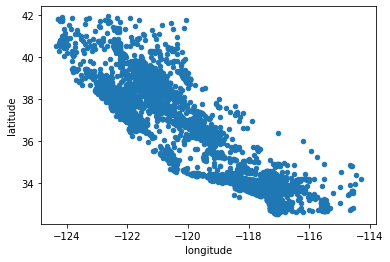

In [20]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

This plot confirms the distribution of latitudes which peak at 34 and 38 and that of longitudes which peaks around -118 and -122.
We can only see the distribution of the population though but not the density for which alpha needs to be added.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

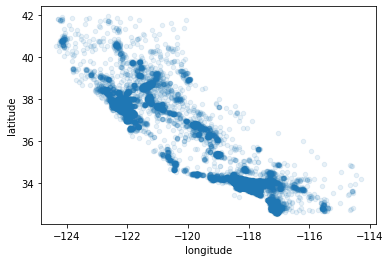

In [21]:
housing.plot(kind = "scatter", x="longitude", y="latitude", alpha=0.1)

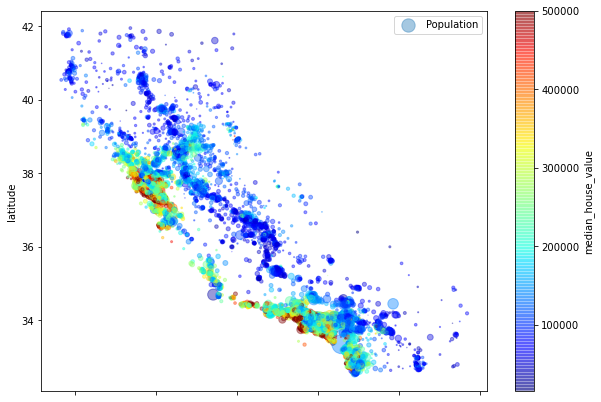

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="Population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values()

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

# Understandings from data so far
1. Location graph shows the variation of housing prices due to the proximity to the ocean. This is not immediately understood from the correlation matrix. So we have to derive a new variable which categorized ocean proximity
2. From correlation matrix, median income in a particular area speaks a lot about the housing prices in the area

We'll get a view of this data using a scatter matrix before focusing on the median income specifically. This will also involve handling the capping of the median income as understood earlier.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

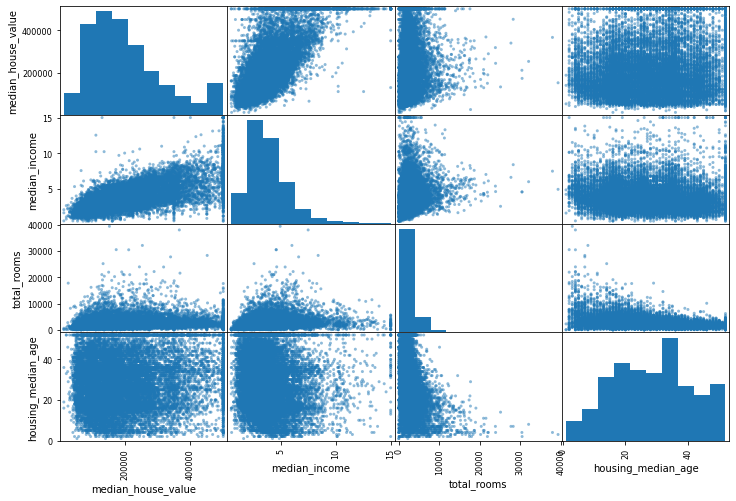

In [24]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

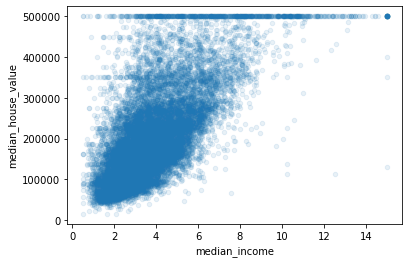

In [25]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='population_per_household', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='median_income'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_income'>,
        <AxesSubplot:xlabel='population_per_household', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='rooms_per_household'>,
        <AxesSubplot:xlabel='median_income', ylabel='rooms_per_household'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='rooms

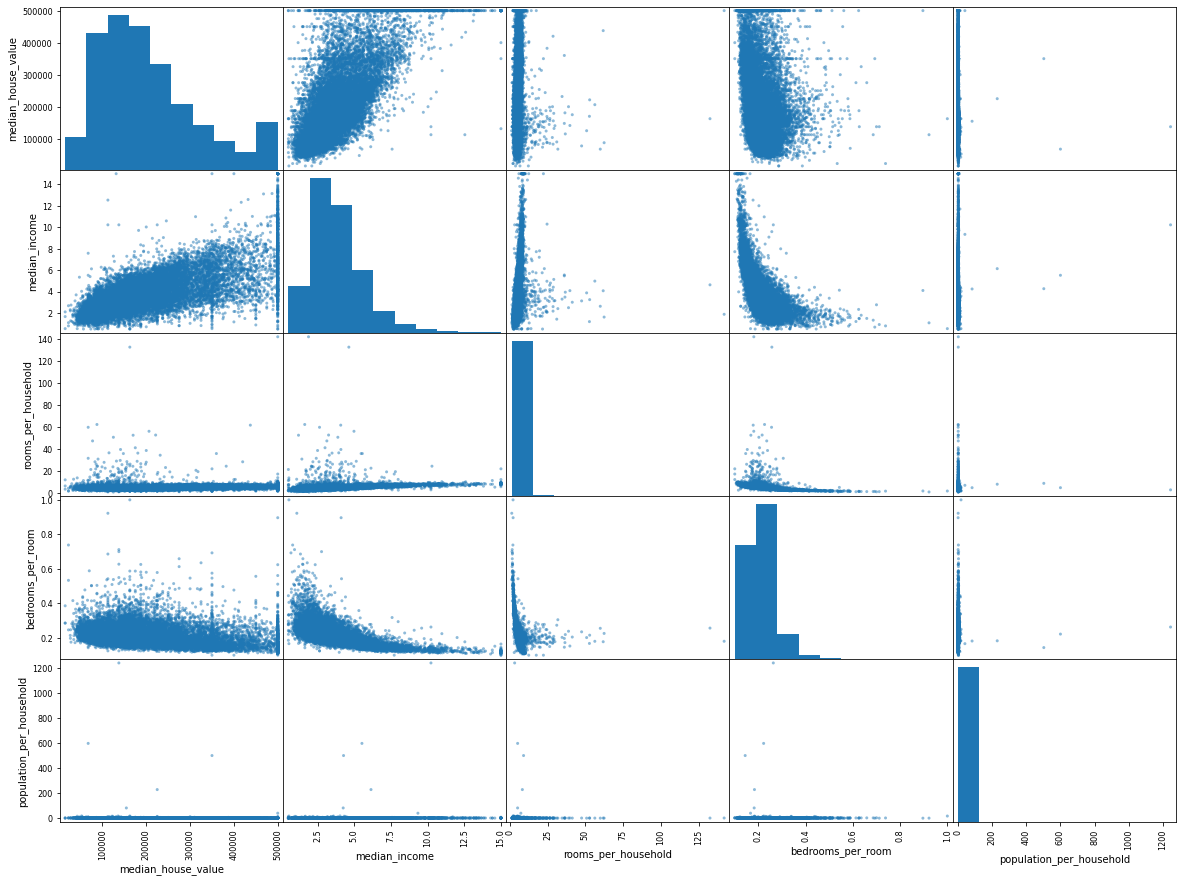

In [26]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

attributes = ["median_house_value", "median_income", "rooms_per_household", "bedrooms_per_room", "population_per_household"]
corr_matrix = housing.corr()
display(corr_matrix["median_house_value"].sort_values(ascending=False))
scatter_matrix(housing[attributes], figsize=(20,15))

In [40]:
strat_train_set = strat_train_set.drop("income_cat", axis=1)
strat_test_set = strat_test_set.drop("income_cat", axis=1)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Preparation of data for Machine Learning algorithm

## Numerical vairables
- Impute missing values for total bedrooms - this is done with the SimpleImputer class using the median imputation strategy
- Do feature scaling

## Text and categorical values
- Ordinal Encoding - issue being that two nearby numbers may not represent categories that are similar
- One-Hot encoding - Create new vars which are binary flags for each category value

In [41]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
housing_num = housing.drop(["ocean_proximity"],axis=1)
imputer.fit(housing_num)

display(imputer.statistics_)
display(housing_num.median().values)

X = imputer.transform(housing_num)
housing_num_tr = pd.DataFrame(X, columns = housing_num.columns)
housing_num_tr.head()

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [42]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
display(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
housing_cat_encoded = one_hot_encoder.fit_transform(housing_cat)
display(one_hot_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin\

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [61]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [64]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [65]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [66]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [67]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [68]:
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Std: ", scores.std())

In [70]:
display_scores(tree_rmse_scores)

Scores:  [68561.00540057 66215.30856089 71255.44754786 70288.20603234
 70070.43551868 74832.82973305 71761.31933567 71506.15346305
 76500.4256322  70018.29024468]
Mean:  71100.94214689978
Std:  2773.4614884826938


In [72]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68024.01273425 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69051.74924793819
Std:  2731.941072269529


In [74]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

RandomForestRegressor()

In [75]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
forest_rmse

18706.656457829933

In [76]:
forest_mse = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
forest_rmse = np.sqrt(-forest_mse)
display_scores(forest_rmse)

Scores:  [49689.34914168 48025.42521021 49752.99153356 52168.57273006
 49755.75525785 53500.7230321  48720.31452637 47856.14476042
 52990.49299133 50204.52034782]
Mean:  50266.42895314008
Std:  1886.3358899906566


In [77]:
from sklearn.model_selection import GridSearchCV
param_grid = [
            {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
            {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
            ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_prepared = full_pipeline.fit_transform(X_test)

bestModel_rmse = np.sqrt(mean_squared_error(Y_test, final_model.predict(X_prepared)))
bestModel_rmse